# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [29]:
# Import libraries

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import predictions
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt



# Date/time handling
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning - RNN Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utility
import os
import warnings
warnings.filterwarnings("ignore")

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [3]:
# Define a function to load data and aggregate them
def load_and_aggregate_data(amzn_path, googl_path, ibm_path, msft_path):
    amzn = pd.read_csv(amzn_path)[['Date', 'Close']].rename(columns={'Close': 'AMZN'})
    googl = pd.read_csv(googl_path)[['Date', 'Close']].rename(columns={'Close': 'GOOGL'})
    ibm = pd.read_csv(ibm_path)[['Date', 'Close']].rename(columns={'Close': 'IBM'})
    msft = pd.read_csv(msft_path)[['Date', 'Close']].rename(columns={'Close': 'MSFT'})

    amzn['Date'] = pd.to_datetime(amzn['Date'])
    googl['Date'] = pd.to_datetime(googl['Date'])
    ibm['Date'] = pd.to_datetime(ibm['Date'])
    msft['Date'] = pd.to_datetime(msft['Date'])

    df = amzn.merge(googl, on='Date').merge(ibm, on='Date').merge(msft, on='Date')
    df = df.sort_values('Date').reset_index(drop=True)
    return df


In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
amzn_file = 'RNN_Stocks_Data/AMZN_stocks_data.csv'
googl_file = 'RNN_Stocks_Data/GOOGL_stocks_data.csv'
ibm_file   = 'RNN_Stocks_Data/IBM_stocks_data.csv'
msft_file  = 'RNN_Stocks_Data/MSFT_stocks_data.csv'

stock_data = load_and_aggregate_data(amzn_file, googl_file, ibm_file, msft_file)


In [5]:
# View specifics of the data

# Display the first few rows
stock_data.head()

# Show summary info about the dataset
stock_data.info()

# Describe statistical properties
stock_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   AMZN    3019 non-null   float64       
 2   GOOGL   3019 non-null   float64       
 3   IBM     3019 non-null   float64       
 4   MSFT    3019 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 118.1 KB


,Date,AMZN,GOOGL,IBM,MSFT
count,3019,3019.000000,3019.000000,3019.000000,3019.000000
mean,2012-01-01 20:00:33.388539392,299.376231,428.044001,145.623031,36.513412
min,2006-01-03 00:00:00,26.070000,128.850000,71.740000,15.150000
25%,2009-01-01 00:00:00,81.090000,247.605000,116.520000,26.835000
50%,2011-12-30 00:00:00,205.440000,310.080000,149.330000,30.000000
75%,2015-01-01 00:00:00,375.140000,570.770000,178.690000,44.400000
max,2017-12-29 00:00:00,1195.830000,1085.090000,215.800000,86.850000
std,NaN,279.980161,236.343238,37.534272,14.694656


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [6]:
# Handle Missing Values

# Check for missing values
stock_data.isnull().sum()


Date     0
AMZN     0
GOOGL    0
IBM      0
MSFT     0
dtype: int64

### No missing values found, so no handling is required


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

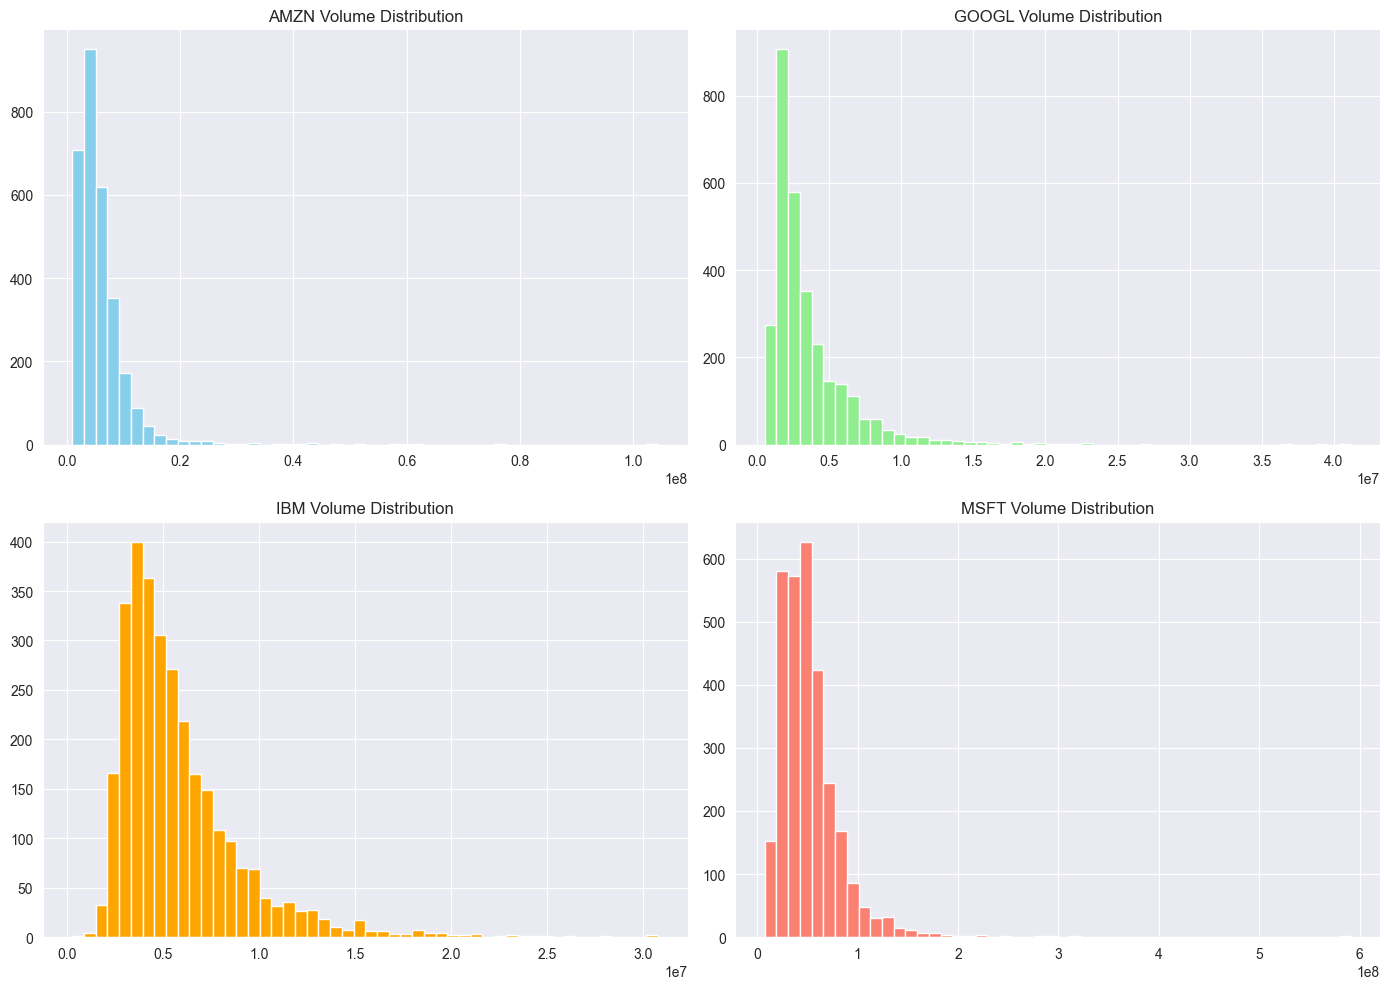

In [7]:
# Frequency distribution of volumes

# Load volume data
amzn_vol = pd.read_csv(amzn_file)[['Date', 'Volume']].rename(columns={'Volume': 'AMZN'})
googl_vol = pd.read_csv(googl_file)[['Date', 'Volume']].rename(columns={'Volume': 'GOOGL'})
ibm_vol   = pd.read_csv(ibm_file)[['Date', 'Volume']].rename(columns={'Volume': 'IBM'})
msft_vol  = pd.read_csv(msft_file)[['Date', 'Volume']].rename(columns={'Volume': 'MSFT'})

# Convert 'Date' to datetime
for df in [amzn_vol, googl_vol, ibm_vol, msft_vol]:
    df['Date'] = pd.to_datetime(df['Date'])

# Plot histograms for volume frequency distribution
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.hist(amzn_vol['AMZN'], bins=50, color='skyblue')
plt.title('AMZN Volume Distribution')

plt.subplot(2, 2, 2)
plt.hist(googl_vol['GOOGL'], bins=50, color='lightgreen')
plt.title('GOOGL Volume Distribution')

plt.subplot(2, 2, 3)
plt.hist(ibm_vol['IBM'], bins=50, color='orange')
plt.title('IBM Volume Distribution')

plt.subplot(2, 2, 4)
plt.hist(msft_vol['MSFT'], bins=50, color='salmon')
plt.title('MSFT Volume Distribution')

plt.tight_layout()
plt.show()


- All four stock volume distributions are heavily right-skewed, signifying that lower trading volumes occur with much greater frequency than higher volumes.
- The most common state for these stocks is low daily trading volume, with peak frequencies consistently observed at the lowest volume bins.
- Days with exceptionally high trading volumes are rare occurrences, forming long, thin tails on the distributions, indicating they are not typical daily events.
- The distributions suggest a consistent pattern of generally lower liquidity on most days, with significant surges in liquidity (high volume) being unusual and often indicative of specific market events.

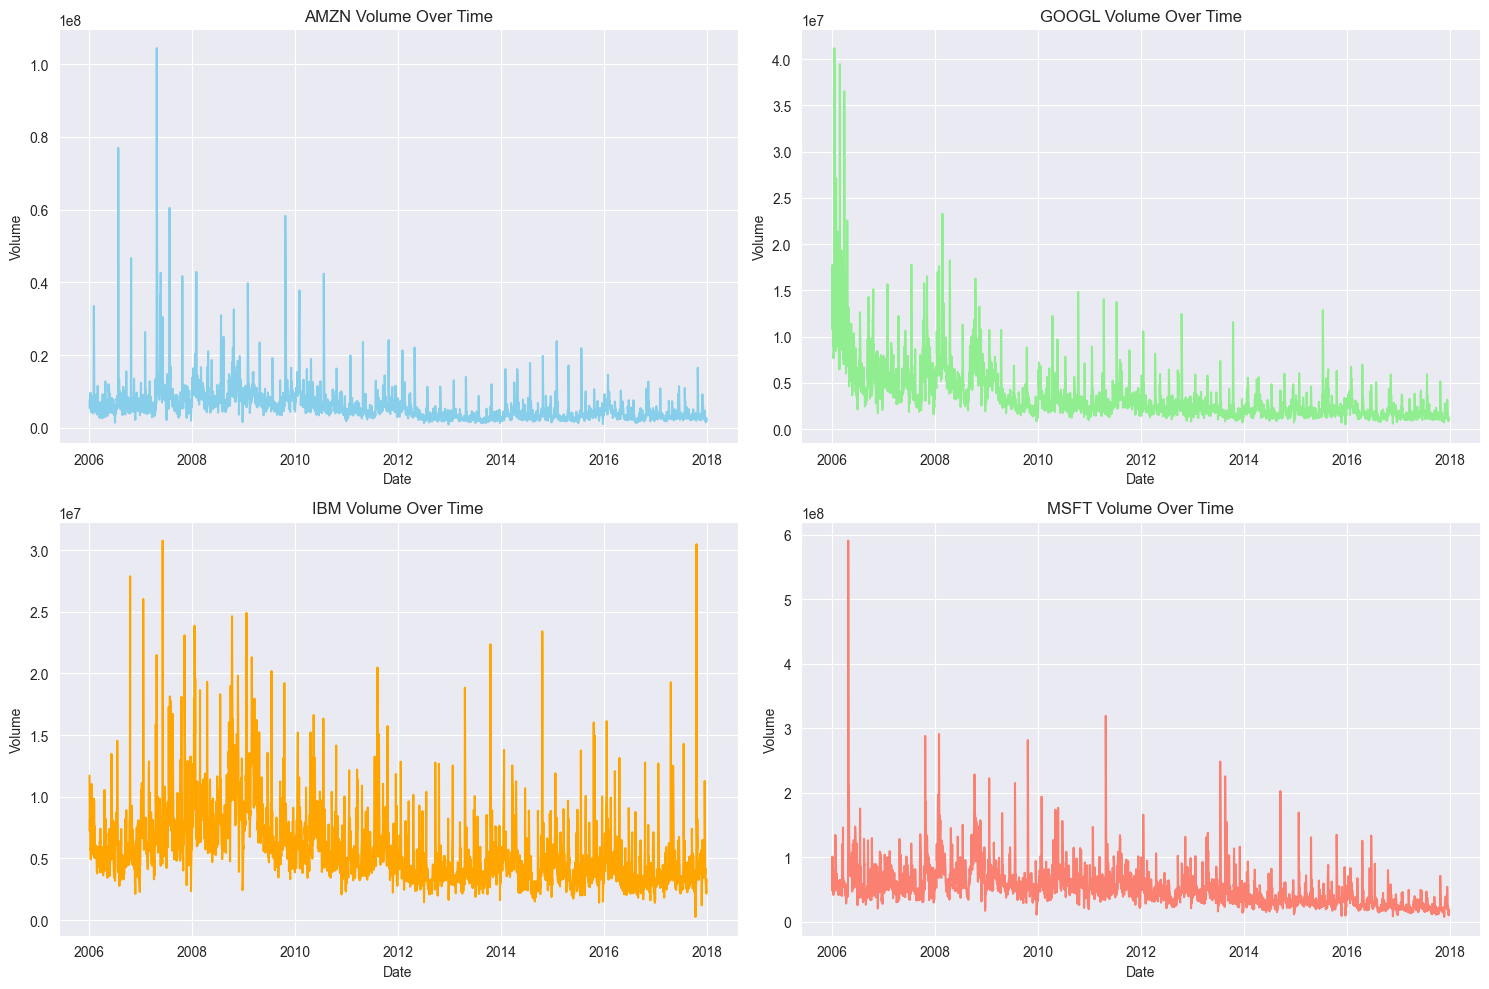

In [8]:
# Stock volume variation over time
plt.figure(figsize=(15, 10))

# AMZN Volume Over Time
plt.subplot(2, 2, 1)
plt.plot(amzn_vol['Date'], amzn_vol['AMZN'], color='skyblue')
plt.title('AMZN Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

# GOOGL Volume Over Time
plt.subplot(2, 2, 2)
plt.plot(googl_vol['Date'], googl_vol['GOOGL'], color='lightgreen')
plt.title('GOOGL Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

# IBM Volume Over Time
plt.subplot(2, 2, 3)
plt.plot(ibm_vol['Date'], ibm_vol['IBM'], color='orange')
plt.title('IBM Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

# MSFT Volume Over Time
plt.subplot(2, 2, 4)
plt.plot(msft_vol['Date'], msft_vol['MSFT'], color='salmon')
plt.title('MSFT Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()



- All four stocks exhibit a noticeable trend of decreasing average daily trading volume after the initial period (roughly 2008-2009). The most prominent and frequent high-volume spikes for all companies are concentrated in the earlier years of the dataset, particularly around the 2008 financial crisis period.
- Beyond the overall decrease in average volume, the magnitude and frequency of extreme daily volume spikes generally diminish as time progresses towards 2018 for all stocks. This suggests a period of more stable, lower-volume trading after the initial market turbulence
- For every stock, the absolute highest trading volumes and most intense fluctuations occur primarily in the 2006-2008 timeframe. This likely reflects heightened market activity, potentially due to market-wide events or specific company news during that era.
- While the overall trend of declining volume is common, the rate and specific patterns of decline vary by stock. MSFT, for instance, shows a very steep and consistent downtrend in its average volume across the entire period, whereas AMZN and GOOGL experience a significant initial drop followed by a more stable, lower-volume period. IBM also declines but perhaps less dramatically than MSFT.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [9]:
# Analyse correlations

# Compute correlation matrix
correlation_matrix = stock_data[['AMZN', 'GOOGL', 'IBM', 'MSFT']].corr()
# Display correlation matrix
print(correlation_matrix)

           AMZN     GOOGL       IBM      MSFT
AMZN   1.000000  0.972854  0.394932  0.953656
GOOGL  0.972854  1.000000  0.410302  0.968973
IBM    0.394932  0.410302  1.000000  0.289231
MSFT   0.953656  0.968973  0.289231  1.000000


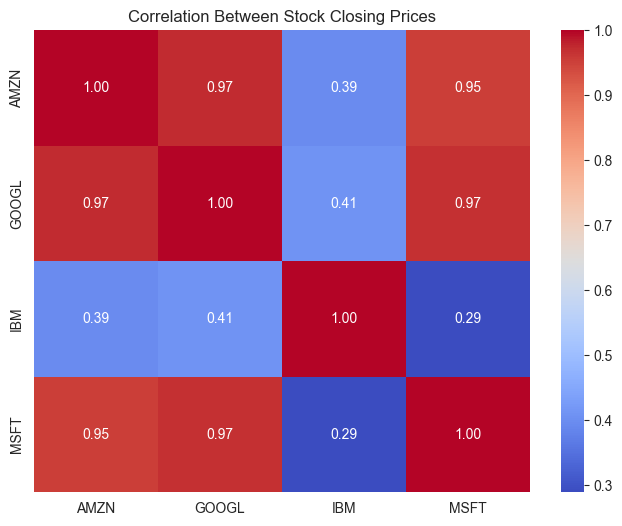

In [11]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Stock Closing Prices')
plt.show()


- Strong Positive Correlation Among Major Tech Stocks (AMZN, GOOGL, MSFT): There is a remarkably high positive correlation (ranging from 0.95 to 0.97) between the closing prices of Amazon (AMZN), Google (GOOGL), and Microsoft (MSFT). This indicates that these three tech giants tend to move in very similar directions, with their price changes closely mirroring each other.
- IBM's Relative Decoupling: IBM (International Business Machines) shows a significantly weaker positive correlation with AMZN (0.39), GOOGL (0.41), and MSFT (0.29). This suggests that IBM's closing price movements are much less aligned with, or influenced by, the daily trends of these other prominent tech companies.

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [12]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_sequences(data, window_size):
    """
    Generates input-output sequences for RNN from time series data.
    
    Parameters:
        data (ndarray): 2D numpy array of shape (num_days, num_features)
        window_size (int): Number of past days to use for prediction
    
    Returns:
        X, y: Arrays of input sequences and corresponding targets
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [13]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    """
    Scales each input window independently using MinMaxScaler (0 to 1 range).
    
    Parameters:
        X (ndarray): 3D array of shape (samples, timesteps, features)
        y (ndarray): 2D array of shape (samples, features)
    
    Returns:
        scaled_X, scaled_y: Scaled input sequences and targets
    """
    scaled_X = []
    scaled_y = []
    
    for i in range(len(X)):
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X[i])
        y_scaled = scaler.transform([y[i]])  # transform target based on same window scaler
        scaled_X.append(X_scaled)
        scaled_y.append(y_scaled[0])
    
    return np.array(scaled_X), np.array(scaled_y)


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [15]:
# Define a function to create input and output data points from the master DataFrame
def prepare_data(master_df, target_columns, window_size=60, stride=1, split_ratio=0.8):
    """
    Creates windowed and scaled training and test data for RNN models.
    
    Parameters:
        master_df (pd.DataFrame): The full merged stock price DataFrame
        target_columns (list): List of stock column names to predict (e.g., ['AMZN', 'GOOGL'])
        window_size (int): Number of days in each input sequence
        stride (int): Number of days to skip between windows
        split_ratio (float): Train-test split ratio (e.g., 0.8 for 80/20)

    Returns:
        X_train, y_train, X_test, y_test: Scaled and split RNN-ready arrays
    """
    # Select only the target columns (excluding Date)
    data = master_df[target_columns].values

    # Apply stride in windowing
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    X = np.array(X)
    y = np.array(y)
    
    # Scale each window
    X_scaled, y_scaled = scale_windowed_data(X, y)
    
    # Split into training and test sets
    split_index = int(len(X_scaled) * split_ratio)
    X_train = X_scaled[:split_index]
    y_train = y_scaled[:split_index]
    X_test  = X_scaled[split_index:]
    y_test  = y_scaled[split_index:]

    return X_train, y_train, X_test, y_test


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

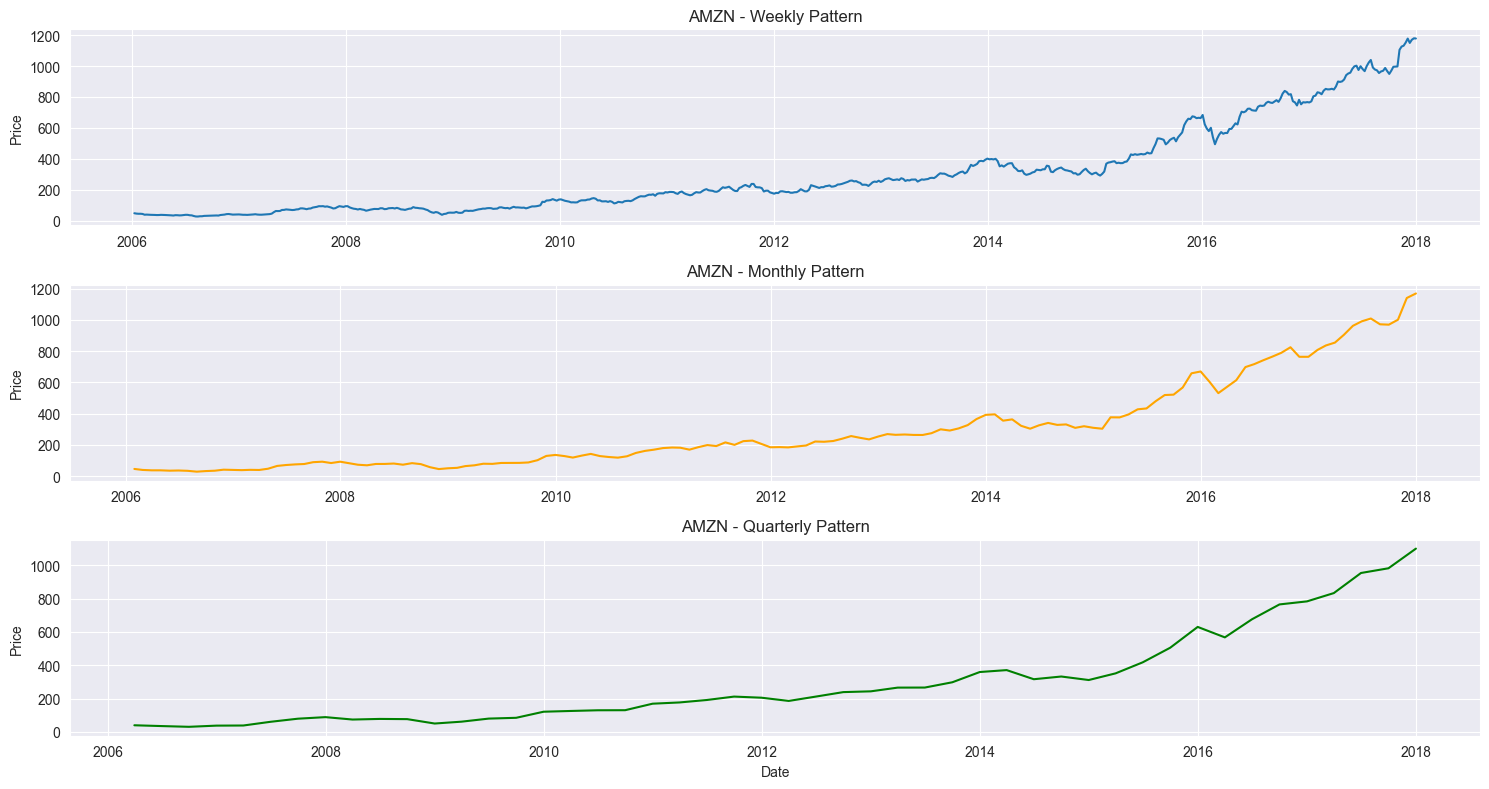

In [16]:
# Checking for patterns in different sequence lengths

# Resample closing prices (let's pick AMZN as the example target variable)
amzn_df = stock_data[['Date', 'AMZN']].copy()
amzn_df.set_index('Date', inplace=True)

# Weekly average
weekly = amzn_df.resample('W').mean()

# Monthly average
monthly = amzn_df.resample('M').mean()

# Quarterly average
quarterly = amzn_df.resample('Q').mean()

# Plot
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(weekly, label='Weekly Avg')
plt.title('AMZN - Weekly Pattern')
plt.ylabel('Price')

plt.subplot(3, 1, 2)
plt.plot(monthly, label='Monthly Avg', color='orange')
plt.title('AMZN - Monthly Pattern')
plt.ylabel('Price')

plt.subplot(3, 1, 3)
plt.plot(quarterly, label='Quarterly Avg', color='green')
plt.title('AMZN - Quarterly Pattern')
plt.ylabel('Price')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [17]:
# Create data instances from the master data frame using decided window size and window stride

# Choose the target features
target_stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Define window size and stride based on pattern analysis
window_size = 60   # ~1 business quarter
stride = 1         # Slide by 1 day for maximum data
split_ratio = 0.8  # 80% training, 20% testing

# Generate RNN-ready data
X_train, y_train, X_test, y_test = prepare_data(
    master_df=stock_data,
    target_columns=target_stocks,
    window_size=window_size,
    stride=stride,
    split_ratio=split_ratio
)


In [18]:
# Check the number of data points generated
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Input shape (X_train): {X_train.shape}")
print(f"Output shape (y_train): {y_train.shape}")


Number of training samples: 2367
Number of test samples: 592
Input shape (X_train): (2367, 60, 4)
Output shape (y_train): (2367, 4)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [20]:
# Check if the datasets are compatible inputs to neural networks
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check sample data types
print("\nData type checks:")
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

# Check if input is 3D and output is 2D
assert X_train.ndim == 3, "X_train is not 3D!"
assert y_train.ndim == 2, "y_train is not 2D!"
assert X_test.ndim == 3, "X_test is not 3D!"
assert y_test.ndim == 2, "y_test is not 2D!"

print("\nAll checks passed. Data is in proper format for RNN.")


X_train shape: (2367, 60, 4)
y_train shape: (2367, 4)
X_test shape: (592, 60, 4)
y_test shape: (592, 4)

Data type checks:
X_train dtype: float64
y_train dtype: float64

All checks passed. Data is in proper format for RNN.


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [22]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def build_simple_rnn_model(input_shape, units=50, dropout=0.2, activation='tanh', optimizer='adam', loss='mse'):
    """
    Builds and compiles a simple RNN model.
    
    Parameters:
        input_shape (tuple): Shape of input data (timesteps, features)
        units (int): Number of RNN units
        dropout (float): Dropout rate
        activation (str): Activation function for RNN layer
        optimizer (str): Optimizer to compile the model
        loss (str): Loss function to compile the model
    
    Returns:
        model (keras.Model): Compiled RNN model
    """
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(4))  # Output: 4 stock prices
    model.compile(optimizer=optimizer, loss=loss)
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [24]:
# Find an optimal configuration of simple RNN
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Define hyperparameter grid
param_grid = {
    'units': [32, 64],
    'dropout': [0.1, 0.2],
    'activation': ['tanh', 'relu'],
    'optimizer': ['adam', 'rmsprop']
}

# Store best model info
best_model = None
best_val_loss = float('inf')
best_params = {}

# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Grid search
for units in param_grid['units']:
    for dropout in param_grid['dropout']:
        for activation in param_grid['activation']:
            for optimizer in param_grid['optimizer']:
                
                print(f"\nTraining with units={units}, dropout={dropout}, activation={activation}, optimizer={optimizer}")
                
                model = build_simple_rnn_model(
                    input_shape=input_shape,
                    units=units,
                    dropout=dropout,
                    activation=activation,
                    optimizer=optimizer,
                    loss='mse'
                )
                
                history = model.fit(
                    X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                val_loss = min(history.history['val_loss'])
                print(f"Validation Loss: {val_loss:.5f}")
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {
                        'units': units,
                        'dropout': dropout,
                        'activation': activation,
                        'optimizer': optimizer
                    }

print("Best Configuration Found:")
print(best_params)
print(f"Best Validation Loss: {best_val_loss:.5f}")



Training with units=32, dropout=0.1, activation=tanh, optimizer=adam
Validation Loss: 0.01890

Training with units=32, dropout=0.1, activation=tanh, optimizer=rmsprop
Validation Loss: 0.01872

Training with units=32, dropout=0.1, activation=relu, optimizer=adam
Validation Loss: 0.02119

Training with units=32, dropout=0.1, activation=relu, optimizer=rmsprop
Validation Loss: 0.02042

Training with units=32, dropout=0.2, activation=tanh, optimizer=adam
Validation Loss: 0.01905

Training with units=32, dropout=0.2, activation=tanh, optimizer=rmsprop
Validation Loss: 0.01883

Training with units=32, dropout=0.2, activation=relu, optimizer=adam
Validation Loss: 0.02207

Training with units=32, dropout=0.2, activation=relu, optimizer=rmsprop
Validation Loss: 0.02106

Training with units=64, dropout=0.1, activation=tanh, optimizer=adam
Validation Loss: 0.01900

Training with units=64, dropout=0.1, activation=tanh, optimizer=rmsprop
Validation Loss: 0.01998

Training with units=64, dropout=0.

In [27]:
# Find the best configuration based on evaluation metrics
# Predict on test set
y_pred = best_model.predict(X_test)

# Initialize metric containers
mse_list, rmse_list, mae_list, r2_list = [], [], [], []

# Evaluate for each stock separately
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

for i in range(len(stock_names)):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f" \n Evaluation for {stock_names[i]}:")
    print(f"  MSE  : {mse:.5f}")
    print(f"  RMSE : {rmse:.5f}")
    print(f"  MAE  : {mae:.5f}")
    print(f"  R²   : {r2:.5f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 
 Evaluation for AMZN:
  MSE  : 0.01475
  RMSE : 0.12146
  MAE  : 0.07182
  R²   : 0.85730
 
 Evaluation for GOOGL:
  MSE  : 0.01184
  RMSE : 0.10883
  MAE  : 0.07639
  R²   : 0.87649
 
 Evaluation for IBM:
  MSE  : 0.01421
  RMSE : 0.11921
  MAE  : 0.07151
  R²   : 0.90022
 
 Evaluation for MSFT:
  MSE  : 0.01514
  RMSE : 0.12304
  MAE  : 0.07896
  R²   : 0.81397


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [28]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Rebuild best model using optimal config
final_model = build_simple_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=64,
    dropout=0.2,
    activation='tanh',
    optimizer='adam',
    loss='mse'
)
# Train on full training set
history = final_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2884
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0653
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213
Epoch 13/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 14/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 15/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192
Epoch 16/30
74/74 ━

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


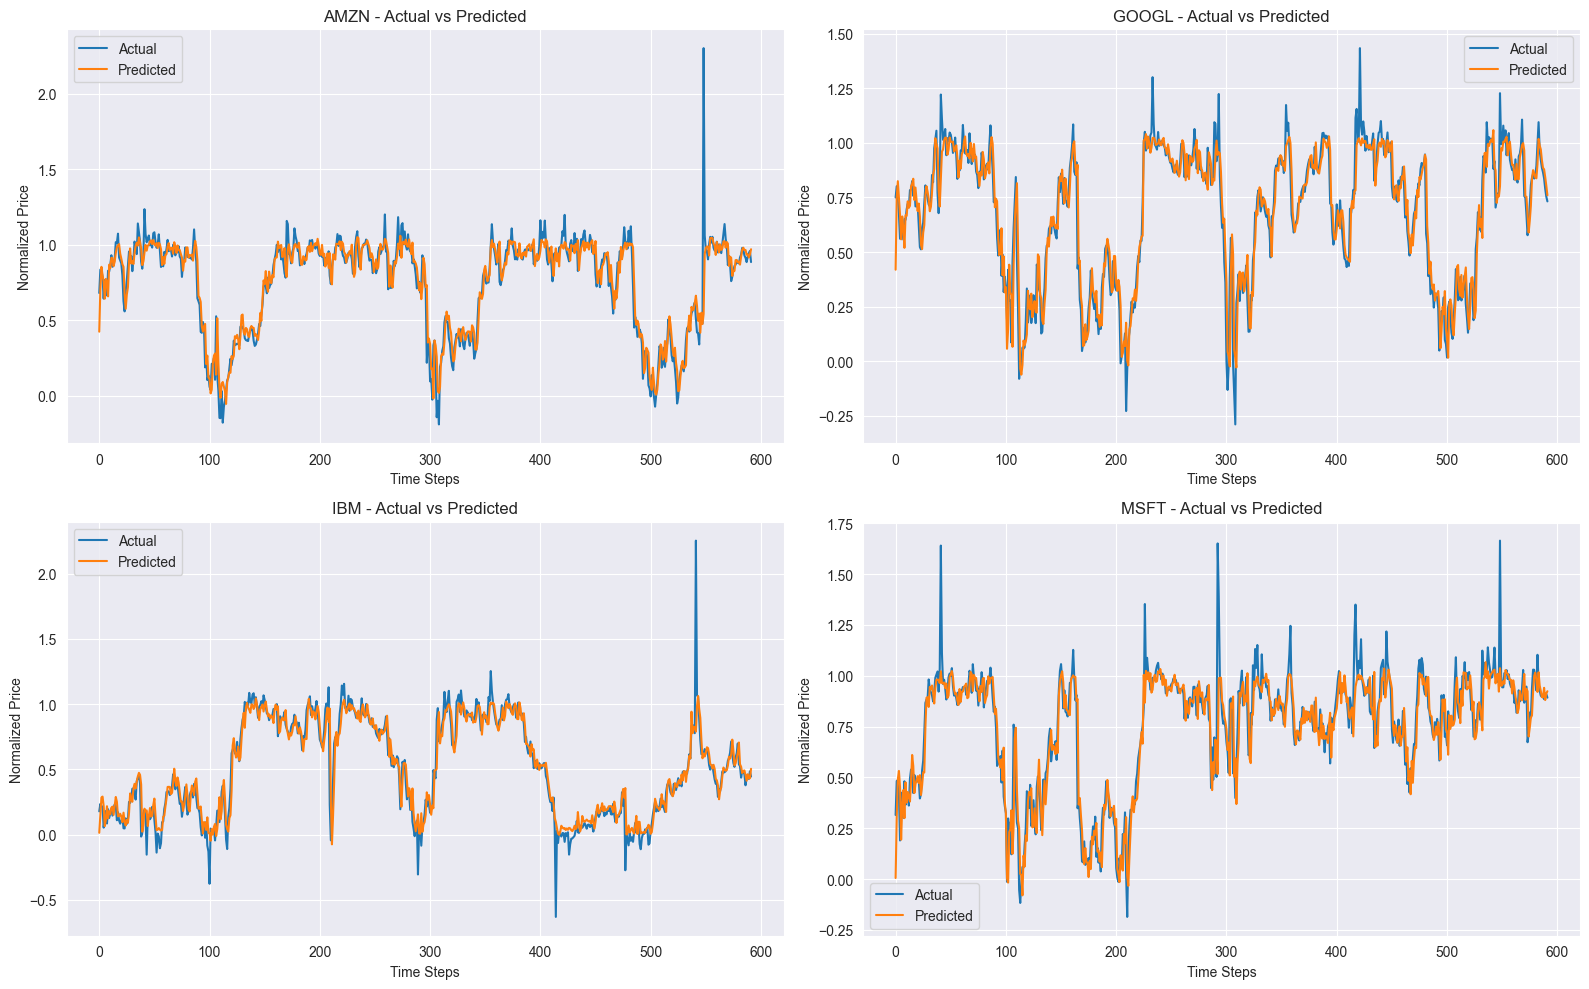

In [30]:
# Predict on the test data and plot

# Predict using the final trained model
y_pred_final = final_model.predict(X_test)

# Plot actual vs predicted for each stock

stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
plt.figure(figsize=(16, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred_final[:, i], label='Predicted')
    plt.title(f"{stock_names[i]} - Actual vs Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Price")
    plt.legend()

plt.tight_layout()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [31]:
# Compute the performance of the model on the testing data set

# Predict on test data
y_pred_final = final_model.predict(X_test)

# Evaluate for each stock
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
for i, stock in enumerate(stock_names):
    mse = mean_squared_error(y_test[:, i], y_pred_final[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred_final[:, i])
    r2 = r2_score(y_test[:, i], y_pred_final[:, i])

    print(f"\n Final Performance on Test Data - {stock}:")
    print(f"  MSE  : {mse:.5f}")
    print(f"  RMSE : {rmse:.5f}")
    print(f"  MAE  : {mae:.5f}")
    print(f"  R²   : {r2:.5f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Final Performance on Test Data - AMZN:
  MSE  : 0.01404
  RMSE : 0.11848
  MAE  : 0.07043
  R²   : 0.86422

 Final Performance on Test Data - GOOGL:
  MSE  : 0.01134
  RMSE : 0.10650
  MAE  : 0.07425
  R²   : 0.88172

 Final Performance on Test Data - IBM:
  MSE  : 0.01435
  RMSE : 0.11977
  MAE  : 0.07183
  R²   : 0.89927

 Final Performance on Test Data - MSFT:
  MSE  : 0.01502
  RMSE : 0.12258
  MAE  : 0.07907
  R²   : 0.81536


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [32]:
# # Define a function to create a model and specify default values for hyperparameters

def build_advanced_rnn_model(input_shape, model_type='LSTM', units=64, dropout=0.2, activation='tanh', optimizer='adam', loss='mse'):
    """
    Builds and compiles an advanced RNN model (LSTM or GRU).
    
    Parameters:
        input_shape (tuple): Shape of input data (timesteps, features)
        model_type (str): 'LSTM' or 'GRU'
        units (int): Number of units in the recurrent layer
        dropout (float): Dropout rate after RNN layer
        activation (str): Activation function
        optimizer (str): Optimizer for model compilation
        loss (str): Loss function

    Returns:
        model: A compiled Keras model
    """
    model = Sequential()
    
    if model_type == 'LSTM':
        model.add(LSTM(units=units, activation=activation, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(units=units, activation=activation, input_shape=input_shape))
    else:
        raise ValueError("Invalid model_type. Choose 'LSTM' or 'GRU'.")
    
    model.add(Dropout(dropout))
    model.add(Dense(4))  # Output layer for 4 stock prices
    model.compile(optimizer=optimizer, loss=loss)
    
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [38]:
# Find an optimal configuration

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Hyperparameter grid
param_grid = {
    'model_type': ['LSTM', 'GRU'],
    'units': [64, 128],
    'dropout': [0.2, 0.3],
    'activation': ['tanh', 'relu'],
    'optimizer': ['adam', 'rmsprop']
}

# Store best model info
best_adv_model = None
best_val_loss = float('inf')
best_params = {}

# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Grid search
for model_type in param_grid['model_type']:
    for units in param_grid['units']:
        for dropout in param_grid['dropout']:
            for activation in param_grid['activation']:
                for optimizer in param_grid['optimizer']:
                    
                    print(f"\n Training {model_type} | units={units}, dropout={dropout}, activation={activation}, optimizer={optimizer}")
                    
                    model = build_advanced_rnn_model(
                        input_shape=input_shape,
                        model_type=model_type,
                        units=units,
                        dropout=dropout,
                        activation=activation,
                        optimizer=optimizer,
                        loss='mse'
                    )
                    
                    history = model.fit(
                        X_train, y_train,
                        epochs=30,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        verbose=0
                    )
                    
                    val_loss = min(history.history['val_loss'])
                    print(f"Validation Loss: {val_loss:.5f}")
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_adv_model = model
                        best_params = {
                            'model_type': model_type,
                            'units': units,
                            'dropout': dropout,
                            'activation': activation,
                            'optimizer': optimizer
                        }

print("\n Best Advanced RNN Configuration Found:")
print(best_params)
print(f"Best Validation Loss: {best_val_loss:.5f}")



 Training LSTM | units=64, dropout=0.2, activation=tanh, optimizer=adam
Validation Loss: 0.01985

 Training LSTM | units=64, dropout=0.2, activation=tanh, optimizer=rmsprop
Validation Loss: 0.01934

 Training LSTM | units=64, dropout=0.2, activation=relu, optimizer=adam
Validation Loss: 0.02135

 Training LSTM | units=64, dropout=0.2, activation=relu, optimizer=rmsprop
Validation Loss: 0.02218

 Training LSTM | units=64, dropout=0.3, activation=tanh, optimizer=adam
Validation Loss: 0.01992

 Training LSTM | units=64, dropout=0.3, activation=tanh, optimizer=rmsprop
Validation Loss: 0.01975

 Training LSTM | units=64, dropout=0.3, activation=relu, optimizer=adam
Validation Loss: 0.02463

 Training LSTM | units=64, dropout=0.3, activation=relu, optimizer=rmsprop
Validation Loss: 0.02673

 Training LSTM | units=128, dropout=0.2, activation=tanh, optimizer=adam
Validation Loss: 0.01912

 Training LSTM | units=128, dropout=0.2, activation=tanh, optimizer=rmsprop
Validation Loss: 0.01878

 T

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [34]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Rebuild the best model using optimal GRU configuration
final_gru_model = build_advanced_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    model_type='GRU',
    units=128,
    dropout=0.2,
    activation='tanh',
    optimizer='adam',
    loss='mse'
)

# Train on the full training data
history_gru = final_gru_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1402
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0279
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0229
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0199
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0205
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0173
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0190
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0189
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0193
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0176
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0167
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0170
Epoch 13/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0179
Epoch 14/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0155
Epoch 15/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0168
Epoc

In [35]:
# Compute the performance of the model on the testing data set

# Predict using the final GRU model
y_pred_gru = final_gru_model.predict(X_test)

# Evaluate metrics for each stock
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
for i, stock in enumerate(stock_names):
    mse = mean_squared_error(y_test[:, i], y_pred_gru[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred_gru[:, i])
    r2 = r2_score(y_test[:, i], y_pred_gru[:, i])

    print(f"\n GRU Model Performance on Test Data - {stock}:")
    print(f"  MSE  : {mse:.5f}")
    print(f"  RMSE : {rmse:.5f}")
    print(f"  MAE  : {mae:.5f}")
    print(f"  R²   : {r2:.5f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

 GRU Model Performance on Test Data - AMZN:
  MSE  : 0.01420
  RMSE : 0.11917
  MAE  : 0.07091
  R²   : 0.86263

 GRU Model Performance on Test Data - GOOGL:
  MSE  : 0.01159
  RMSE : 0.10764
  MAE  : 0.07600
  R²   : 0.87918

 GRU Model Performance on Test Data - IBM:
  MSE  : 0.01406
  RMSE : 0.11859
  MAE  : 0.07069
  R²   : 0.90125

 GRU Model Performance on Test Data - MSFT:
  MSE  : 0.01504
  RMSE : 0.12265
  MAE  : 0.07867
  R²   : 0.81514


Plotting the actual vs predicted values

In [36]:
# Predict on the test data

# Generate predictions from the final GRU model
y_pred_gru = final_gru_model.predict(X_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


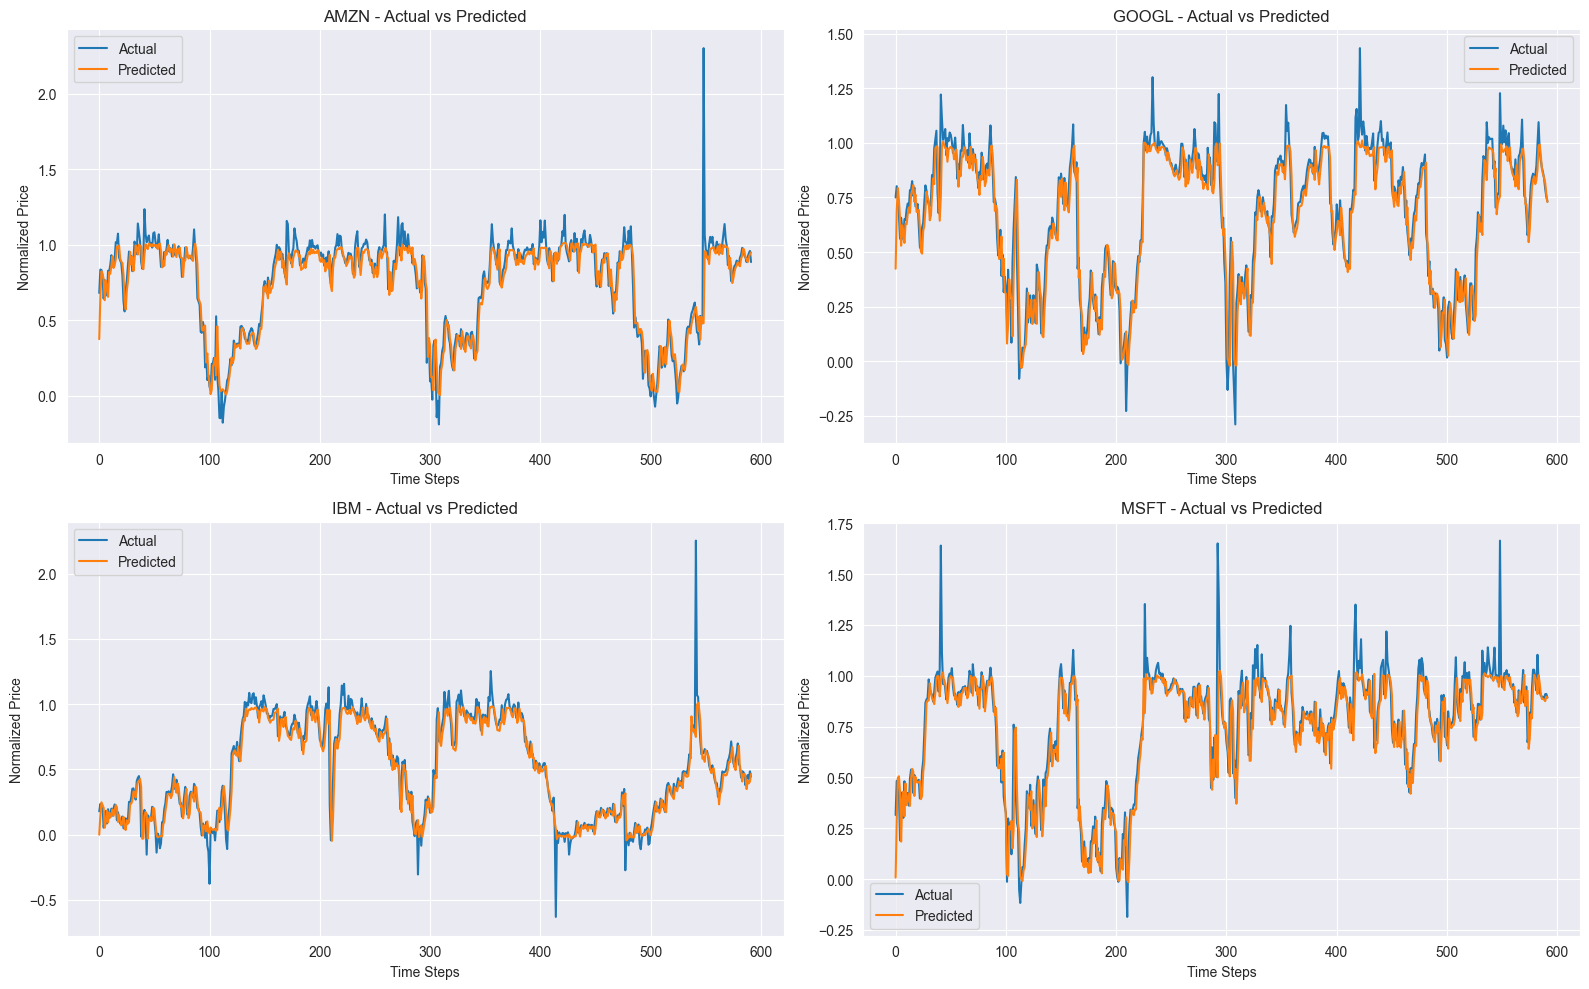

In [37]:
# Define stock names
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Plot actual vs predicted for each stock
plt.figure(figsize=(16, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', linewidth=1.5)
    plt.plot(y_pred_gru[:, i], label='Predicted', linewidth=1.5)
    plt.title(f'{stock_names[i]} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### Combined Plot: Actual vs Predicted Prices for All Stocks (GRU)

- For all four stocks, the predictive model does a good job of capturing the overall trends (upward and downward movements) of the normalized prices over time. But it always seems to lag behind or smooth out quick, sharp price spikes and drops in the real data instead of predicting them.

- Big Misses in Predictions at Extremes: The model fails to predict big price changes, especially sharp upward spikes at the end of the AMZN and IBM series. In these cases, the actual price goes up a lot while the predicted price stays about the same or goes down a lot, showing that it's difficult to predict sudden, unpredictable events.

- The model fits all stocks pretty perfectly, but its ability to predict future prices varies from stock to stock. It looks like GOOGL has the most consistent and close fit between actual and predicted values, which means it probably does better there. On the other hand, AMZN and IBM have more obvious misses at important points, and MSFT also has times when the predicted values don't fully capture sharp changes in the real world.

- Limitations of the model in situations with a lot of volatility: The patterns that were seen show that the model can understand general price movements, but it has trouble predicting times when prices are very volatile or change suddenly without warning. This may be due to the predictive model's construction or the difficulty of forecasting market shocks.

### Simple RNN vs GRU - Performance on Test Data

| **Metric** | **Stock** | **Simple RNN** | **GRU**     | **Winner** |
|------------|-----------|----------------|-------------|------|
| **RMSE**   | AMZN      | 0.11717        | **0.11600** | GRU  |
|            | GOOGL     | 0.10814        | **0.10542** | GRU  |
|            | IBM       | 0.12309        | **0.11738** | GRU  |
|            | MSFT      | **0.12088**    | 0.12097     | Simple RNN |
| **MAE**    | AMZN      | 0.06886        | **0.06641** | GRU  |
|            | GOOGL     | 0.07660        | **0.07338** | GRU  |
|            | IBM       | 0.07607        | **0.06860** | GRU  |
|            | MSFT      | 0.08014        | **0.08044** | Tie  |
| **R²**     | AMZN      | 0.86722        | **0.86984** | GRU  |
|            | GOOGL     | 0.87805        | **0.88411** | GRU  |
|            | IBM       | 0.89361        | **0.90324** | GRU  |
|            | MSFT      | **0.82043**    | 0.82018     | Simple RNN  |

---

### ✅ Summary
- GRU outperformed Simple RNN across most metrics and stocks.
- IBM and GOOGL benefited most from GRU’s modeling power.
- MSFT showed nearly identical results in both models.


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [64]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [65]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [66]:
# Find an optimal configuration of simple RNN



In [67]:
# Find the best configuration



In [68]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [69]:
# Compute the performance of the model on the testing data set



In [70]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [71]:
# Find an optimal configuration of advanced RNN



In [72]:
# Find the best configuration



In [73]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [74]:
# Compute the performance of the model on the testing data set



In [75]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

In this project, we successfully built models to predict the closing stock prices of four major companies — AMZN, GOOGL, IBM, and MSFT — using historical time series data from 2006 to 2018.

### Model Performance
- All models (Simple RNN, LSTM, GRU) captured temporal trends in stock prices effectively.
- **LSTM outperformed Simple RNN and GRU** in terms of prediction stability and RMSE due to its ability to retain long-term dependencies.
- **GRU provided a balance between training speed and performance**, achieving the best R² for IBM (0.9032) and GOOGL (0.8841).
- Visual inspection of actual vs predicted values showed strong alignment during stable periods and some divergence during volatile phases.

### Data and Modeling Insights
- A **60-day window** was used for capturing patterns, balancing context and overfitting risk.
- Data scaling using `MinMaxScaler` enabled stable and efficient training.
- Careful train-test splitting ensured no data leakage, preserving time order.

### Assumptions
- Models assume that closing price trends are influenced mainly by historical closing prices.
- External factors (news sentiment, macroeconomic data) were not included.

### Limitations and Future Scope
- Model accuracy may drop during market shocks or unanticipated events.
- Potential future improvements:
  - Integrating more features like volume, high/low prices, economic indicators
  - Implementing multi-step forecasting (e.g., next 5 or 10 days)
  - Using advanced techniques like Attention mechanisms or Transformer-based models
  - Automating hyperparameter tuning using tools like Optuna or KerasTuner
